In [ ]:
"""
<친밀도 및 적절성 데이터를 이용한 만족도 예측하기>
"""

'\n<친밀도 및 적절성 데이터를 이용한 만족도 예측하기>\n - 사용 데이터 : drinking_water.csv\n - 사용모델 : 지금까지 배운 모든 모델 활용\n - 데이터 전처리부터 ~ 상관관계 검증 등 모든 사전 처리 진행\n - 특성공학 및 스케일링 등 모든 처리 적용\n - 모델별로 성능 평가 및 해석\n   --> 성능 평가는 특성공학/스케일링/하이퍼파라메터\n       전용 전 후 모두 훈련 평가 후 비교 분석\n - 모델별로 성능 평가 맟 해석\n - 최종 모델 선정\n - 최종 모델로 예측 및 평가 \n - 조별로 자유롭게 진행\n - 제출 : 4조_만족도예측_ipynb\n'

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import set_config
set_config(display="text")
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### 파일 읽어들이기, 시작 

In [6]:
file_path = "04_(실습)_회귀모델_drinking_water.csv"
file = pd.read_csv(file_path)
file

## 독립변수 친밀도, 적절성 
## 종속변수 만족도

,친밀도,적절성,만족도
0,3,4,3
1,3,3,2
2,4,4,4
3,2,2,2
4,2,2,2
...,...,...,...
259,3,4,4
260,3,4,3
261,4,4,4
262,4,4,4


### 사전처리 시작(시각화 및 이상치 확인)

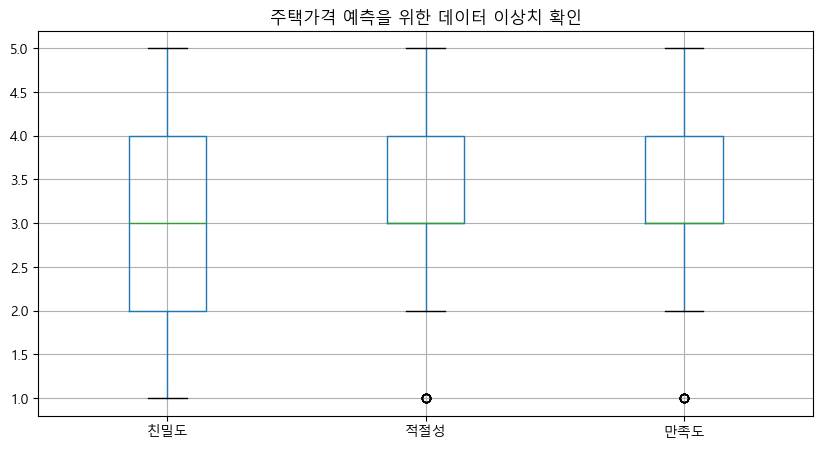

In [7]:
plt.figure(figsize=(10, 5))
plt.title("주택가격 예측을 위한 데이터 이상치 확인")
### 박스플롯 그리기
file.boxplot()
plt.show()

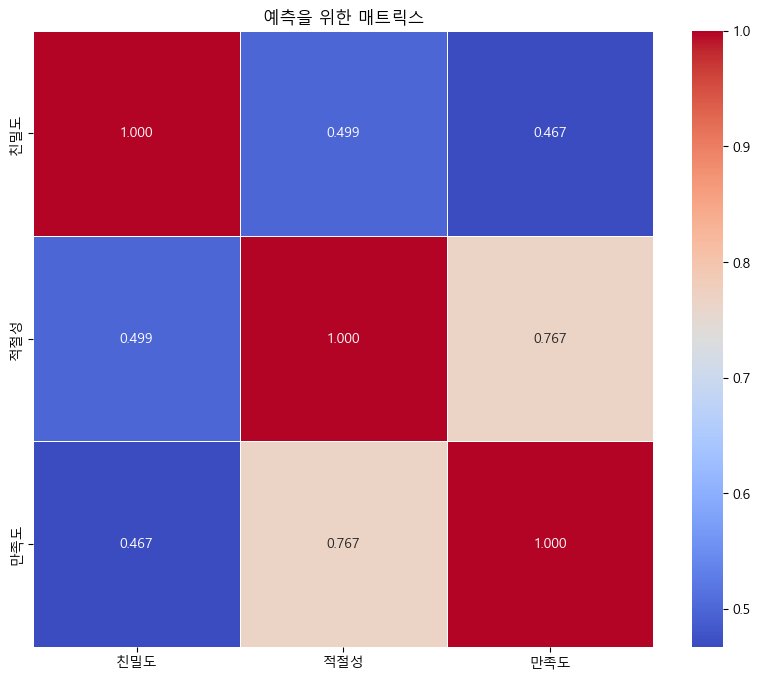

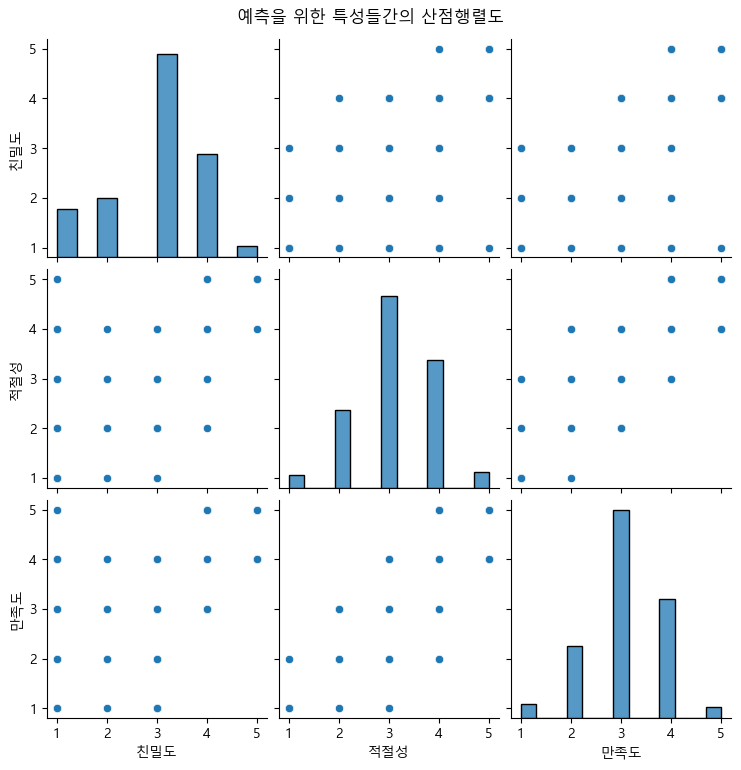

In [17]:
correlation_matrix = file.corr()
correlation_matrix

plt.figure(figsize=(10, 8))
plt.title("예측을 위한 매트릭스")
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", 
            cmap="coolwarm", linewidths=0.5)

sns.pairplot(file)
plt.suptitle("예측을 위한 특성들간의 산점행렬도", y=1.02)
plt.show()

### 해석
# 적설성과 만족도의 상관관계는 0.766으로 적절한 상관관계를 가지고 있으나
# 친밀도와 만족도는 0.467로 영향을 미치는 것으로 판단된다.
# 만족도와 적절성간의 간의 관계는 선형적인 우상향 관계를 그리고 있으며 
# 만족도와 친밀도간의 간의 관계는 우상향 관계를 그리고는 있으나
# 친밀도가 높아도 만족도가 낮은 특정 값이 보이고 있다. 
# 분석을 진행할 경우 모든 관계가 선형적인 분포를 그리고 있다.



In [ ]:
indep = file.iloc[:, :-1]
depen = file["만족도"]
print(indep, depen)

### 상관관계 분석

In [27]:
### 스피어만, 피어슨 상관관계 분석 라이브러리 정의
from scipy.stats import spearmanr
from scipy.stats import pearsonr

indep_column = indep.columns
spearmanr(indep[indep_column[0]],depen)


SignificanceResult(statistic=0.5012006658643047, pvalue=3.383407076477574e-18)

In [29]:
for i in indep_column :
    s, p = spearmanr(indep[i],depen)
    i_msg = "유의미 하지 않음"
    
    if p < 0.05 : 
        i_msg = "유의미 함"
        
    msg = f"""
        독립변수({i})와 종속변수(만족도)의 상관관계 계수는 {s:.3f}이고, 
        p-value의 값은 {p}임. 따라서 p-value < 0.05에 대하여 {i_msg}
    """
    print(msg)
    
### (해석) 
# 친밀도와, 적절성은 종속변수인 만족도와의 상관계수는 0.501과 0.749로 나타나며
# p-valuesms 10^48, 10^18 으로 매우 작은값으로 표기되며 유의미한 값이 도출되었다.


        독립변수(친밀도)와 종속변수(만족도)의 상관관계 계수는 0.501이고, 
        p-value의 값은 3.383407076477574e-18임. 따라서 p-value < 0.05에 대하여 유의미 함
    

        독립변수(적절성)와 종속변수(만족도)의 상관관계 계수는 0.749이고, 
        p-value의 값은 1.1877299204509877e-48임. 따라서 p-value < 0.05에 대하여 유의미 함
    


In [41]:
indep_train, indep_temp, depen_train, depen_temp = train_test_split(indep, depen,test_size=0.4, random_state=42)
indep_val, indep_test, depen_val, depen_test = train_test_split(indep_temp, depen_temp, test_size=0.5, random_state=42)

print(indep_train.shape, depen_train.shape)
print(indep_val.shape, depen_val.shape)
print(indep_test.shape, depen_test.shape)

(158, 2) (158,)
(53, 2) (53,)
(53, 2) (53,)


### 사전처리 완료

In [55]:
liner_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
rf_reg    = RandomForestRegressor()
ext_reg   = ExtraTreesRegressor()
gb_reg    = GradientBoostingRegressor()
hgb_reg   = HistGradientBoostingRegressor()
xgb_reg   = XGBRegressor()

models = [liner_reg, ridge_reg, lasso_reg, rf_reg, ext_reg, gb_reg, hgb_reg, xgb_reg]
models

[LinearRegression(),
 Ridge(),
 Lasso(),
 RandomForestRegressor(),
 ExtraTreesRegressor(),
 GradientBoostingRegressor(),
 HistGradientBoostingRegressor(),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)]

In [56]:
### 기본 데이터로 8개의 모델로 훈련해보기 
for model in models :
    model_name = model.__class__.__name__
    
    model.fit(indep_train, depen_train)
    
    train_score = model.score(indep_train, depen_train)
    val_score = model.score(indep_val, depen_val)
    
    train_pred = model.predict(indep_train)
    val_pred   = model.predict(indep_val)

    train_mae = mean_absolute_error(depen_train, train_pred)
    val_mae   = mean_absolute_error(depen_val, val_pred)
    
    train_mse = mean_squared_error(depen_train, train_pred)
    val_mse   = mean_squared_error(depen_val, val_pred)
    
    train_r2 = r2_score(depen_train, train_pred)
    val_r2   = r2_score(depen_val, val_pred)
    
    print(f"----{model_name}----")
    print(f"훈련:{train_score}, 검증:{val_score}, 과적합여부:{train_score-val_score}")
    print(f"훈련mae:{train_mae},검증mae:{val_mae},훈련mse:{train_mse},검증mse:{val_mse},훈련R2:{train_r2},검증R2:{val_r2},")
    



### 훈련 : 0.5987, 테스트 : 0.4601, 과적합여부 : 0.1385, mae : (+-) 41.6의 오차 발생 가능성이 있음.
# (해석) 훈련정확도, 테스트정확도는 각 위와 같이 나왔으며 
# 과적합여부의 수치가 0.1385로 0.1이 넘어가 과대적합으로 판단됩니다.
# 훈련 정확도와 테스트 정확도 모두 낮게 나오므로 특성공학 및 스케일링을 하여 성능을 향상 시켜야 할 것으로 예상됨

----LinearRegression----
훈련:0.5987371268157204, 검증:0.5561186759760699, 과적합여부:0.042618450839650546
훈련mae:0.4044360465867078,검증mae:0.36117516701782576,훈련mse:0.2945980587935217,검증mse:0.2247060315991558,훈련R2:0.5987371268157204,검증R2:0.5561186759760699,
----Ridge----
훈련:0.5987002498115315, 검증:0.5576298973284843, 과적합여부:0.041070352483047134
훈련mae:0.4053506731120574,검증mae:0.36119475220151115,훈련mse:0.29462513304976173,검증mse:0.2239410060515825,훈련R2:0.5987002498115315,검증R2:0.5576298973284843,
----Lasso----
훈련:0.0, 검증:-0.006329113924050667, 과적합여부:0.006329113924050667
훈련mae:0.5949367088607594,검증mae:0.4339622641509434,훈련mse:0.7341772151898734,검증mse:0.5094339622641509,훈련R2:0.0,검증R2:-0.006329113924050667,
----RandomForestRegressor----
훈련:0.6787361532722582, 검증:0.5517352114620275, 과적합여부:0.1270009418102307
훈련mae:0.35648152944394595,검증mae:0.35626705718676416,훈련mse:0.23586459633175985,검증mse:0.22692507273086396,훈련R2:0.6787361532722582,검증R2:0.5517352114620275,
----ExtraTreesRegressor----
훈련:0.680172308803581

### 특성공학 let's go,   2~4차원일 때

In [87]:
### 특성공학 시작 ! / 2~4차원일 때
for degree in range(2,5,1) :
    poly = PolynomialFeatures(degree= degree, include_bias=False)
    poly.fit(indep_train)

    train_poly = poly.transform(indep_train)
    val_poly = poly.transform(indep_val)
    test_poly = poly.transform(indep_test)
# print(temp_poly)  ## [[ 3.  4.  9. 12. 16.] 등등 값

### fit()에서 찾은 패턴 확인하기
# poly.get_feature_names_out()   ## ['친밀도', '적절성', '친밀도^2', '친밀도 적절성', '적절성^2']

    for idx in StandardScaler(),MinMaxScaler(),RobustScaler() :
            
            idx.fit(train_poly)
            train_scaled = idx.transform(train_poly)
            val_scaled = idx.transform(val_poly)
            test_scaled = idx.transform(test_poly)
            print(f"훈련 : {train_score}, 테스트 : {test_score}, 과적합여부: {train_score - test_score}")
            # 예측
            test_pred = lr.predict(test_scaled)
            print(f"예측결과 : {test_pred}")
            # mae 확인
            mae = mean_absolute_error(depen_test, test_pred)
            print(f"예측 mae : {mae}")        
        
print(idx)     
    ### 과적합 여부 해석
    print(f"차원:{degree}, 훈련: {train_score}, 검증:,{val_score}, 테스트: {test_score}, 과적합여부: {train_score - test_score}") 

    # 차원:2, 훈련: 0.6363, 검증:,0.6590, 테스트: 0.5278, 과적합여부: 0.1084
    # 차원:3, 훈련: 0.6462, 검증:,0.6276, 테스트: 0.4500, 과적합여부: 0.1961
    # 차원:4, 훈련: 0.6791, 검증:,0.5194, 테스트: -0.3827, 과적합여부: 1.061

차원:2, 훈련: 0.6363675354324329, 검증:,0.6590858451986996, 테스트: 0.527882217677663, 과적합여부: 0.10848531775476988
차원:3, 훈련: 0.6462672249737099, 검증:,0.6276423384438472, 테스트: 0.45007177141309695, 과적합여부: 0.19619545356061296
차원:4, 훈련: 0.6791812137211701, 검증:,0.5194164636505523, 테스트: -0.38278049920681045, 과적합여부: 1.0619617129279806


### 스케일링 시작 !

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

sns = StandardScaler
mm = MinMaxScaler
rb = RobustScaler
scaleds = [StandardScaler, MinMaxScaler, RobustScaler]

In [88]:
for idx in StandardScaler(),MinMaxScaler(),RobustScaler() :
        
        idx.fit(train_poly)
        train_scaled = idx.transform(train_poly)
        val_scaled = idx.transform(val_poly)
        test_scaled = idx.transform(test_poly)
        print(f"훈련 : {train_score}, 테스트 : {test_score}, 과적합여부: {train_score - test_score}")
        # 예측
        test_pred = lr.predict(test_scaled)
        print(f"예측결과 : {test_pred}")
        # mae 확인
        mae = mean_absolute_error(depen_test, test_pred)
        print(f"예측 mae : {mae}")        
        
print(idx)       

훈련 : 0.6791812137211701, 테스트 : -0.38278049920681045, 과적합여부: 1.0619617129279806
예측결과 : [ -4.64593854 -11.98188602  -4.64593854  -1.71810809 -11.98188602
 -12.53028636  -4.64593854  -4.64593854  -8.16417118   3.48518504
   1.40237408  -1.71810809  -1.71810809  -1.71810809  -8.79728546
  -1.80170563   1.40237408 -14.64569378   1.40237408 -10.99251915
  -8.79728546  -1.80170563   1.40237408   1.40237408  -1.80170563
 -17.40331202  -1.80170563  -8.16417118 -11.98188602   1.40237408
   1.40237408  -4.64593854  -4.64593854  -8.79728546  -8.16417118
  -8.79728546 -14.64569378 -14.64569378  -4.64593854 -17.40331202
   1.40237408   1.40237408  -4.64593854   1.40237408 -11.98188602
  -4.64593854   6.39951763  -8.16417118  -4.64593854  -4.64593854
  -1.80170563   1.40237408  -4.64593854]
예측 mae : 8.455855137184406
훈련 : 0.6791812137211701, 테스트 : -0.38278049920681045, 과적합여부: 1.0619617129279806
예측결과 : [-1.48271258 -3.16311721 -1.48271258 -0.86988914 -3.16311721 -3.4216138
 -1.48271258 -1.48271258 -2.

In [ ]:
rs_df = pd.DataFrame()
result = {}

for degree in range(1, 5):
    print(degree)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(indep_train)

    train_poly = poly.transform(indep_train)
    val_poly = poly.transform(indep_val)
    test_poly = poly.transform(indep_test)

    ### 과적합 여부 해석
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), None]
    scaler_names = ["StandardScaler", "MinMaxScaler", "RobustScaler", "No Scaling"]

    for scaler, scaler_name in zip(scalers, scaler_names):  # 모든 스케일러 반복 적용
        if scaler is not None:  # 스케일링 적용
            scaler.fit(train_poly)
            train_scaled = scaler.transform(train_poly)
            val_scaled = scaler.transform(val_poly)
            test_scaled = scaler.transform(test_poly)
        else:  # 스케일링 미적용
            train_scaled = train_poly
            val_scaled = val_poly
            test_scaled = test_poly

        for model in models:
            model_nm = model.__class__.__name__

            # 모델별 하이퍼파라미터 설정
            gridParams = {}
            if model_nm in ["LinearRegression", "Ridge", "Lasso"]:
                gridParams = linear_params
            elif model_nm == "GradientBoostingRegressor":
                gridParams = gb_params
            elif model_nm == "HistGradientBoostingRegressor":
                gridParams = hgb_params
            else:
                gridParams = rf_et_xgb_params
            ###  기본 모델 (하이퍼파라미터 적용 X) 
            
            default_model = model.__class__()  # 기본 모델 생성
            default_model.fit(train_scaled, depen_train)
            default_train_pred = default_model.predict(train_scaled)
            default_val_pred = default_model.predict(val_scaled)

            # 기본 모델 평가 점수 계산
            default_train_r2 = round(r2_score(depen_train, default_train_pred), 4)
            default_val_r2 = round(r2_score(depen_val, default_val_pred), 4)
            default_train_val_diff = round(default_train_r2 - default_val_r2, 4)

            # 기본 모델 결과 저장
            if (train_val_diff > 0) & (train_val_diff < 0.1) & (train_r2 != 0):
                df_data = pd.DataFrame([[model_nm, degree, scaler_name, train_mae, train_mse, train_r2,
                                            val_mae, val_mse, val_r2, train_val_diff]],
                                        columns=["best_model_nm", "degree", "scaler", "train_mae", "train_mse", "train_r2",
                                                    "val_mae", "val_mse", "val_r2", "train_r2-val_r2"])
                
            # GridSearchCV 실행
            grid_search_model = GridSearchCV(
                estimator=model,
                param_grid=gridParams,
                scoring=scoring,
                refit=refit,
                cv=cv,
                n_jobs=n_jobs)
            grid_search_model.fit(train_scaled, depen_train)

            # 최적의 모델 선택
            best_model = grid_search_model.best_estimator_

            # 훈련 및 검증 예측
            train_pred = best_model.predict(train_scaled)
            val_pred = best_model.predict(val_scaled)

            # 평가 점수 계산
            train_mae = round(mean_absolute_error(depen_train, train_pred), 4)
            train_mse = round(mean_squared_error(depen_train, train_pred), 4)
            train_r2 = round(r2_score(depen_train, train_pred), 4)

            val_mae = round(mean_absolute_error(depen_val, val_pred), 4)
            val_mse = round(mean_squared_error(depen_val, val_pred), 4)
            val_r2 = round(r2_score(depen_val, val_pred), 4)

            train_val_diff = round(train_r2 - val_r2, 4)
            
            if (train_val_diff > 0) & (train_val_diff < 0.1) & (train_r2 != 0):
                msg = f"모델명: {model_nm}, {degree}차원, 사용된 스케일러: {scaler_name}"
                msg += f" 훈련mae: {train_mae}, 훈련mse: {train_mse}, 훈련r2: {train_r2}"
                msg += f" 검증mae: {val_mae}, 검증mse: {val_mse}, 검증r2: {val_r2}"
                msg += f" 과적합여부: {train_val_diff}"
                print(msg, "\n")
                

            # 결과를 데이터프레임에 저장
                df_data = pd.DataFrame([[model_nm, degree, scaler_name, train_mae, train_mse, train_r2,
                                        val_mae, val_mse, val_r2, train_val_diff]],
                                    columns=["best_model_nm", "degree", "scaler", "train_mae", "train_mse", "train_r2",
                                                "val_mae", "val_mse", "val_r2", "train_r2-val_r2"])

                rs_df = pd.concat([rs_df, df_data], ignore_index=True)

    print(f"{degree}차원 튜닝 끝")
    print("----------------------------------------------------------------------------------")

1
모델명: LinearRegression, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.4044, 훈련mse: 0.2946, 훈련r2: 0.5987 검증mae: 0.3612, 검증mse: 0.2247, 검증r2: 0.5561 과적합여부: 0.0426 

모델명: Ridge, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.4052, 훈련mse: 0.2946, 훈련r2: 0.5987 검증mae: 0.3612, 검증mse: 0.2241, 검증r2: 0.5573 과적합여부: 0.0414 

모델명: Lasso, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.5949, 훈련mse: 0.7342, 훈련r2: 0.0 검증mae: 0.434, 검증mse: 0.5094, 검증r2: -0.0063 과적합여부: 0.0063 

모델명: RandomForestRegressor, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.361, 훈련mse: 0.236, 훈련r2: 0.6785 검증mae: 0.3639, 검증mse: 0.2292, 검증r2: 0.5472 과적합여부: 0.1313 

모델명: ExtraTreesRegressor, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.3534, 훈련mse: 0.2348, 훈련r2: 0.6802 검증mae: 0.3708, 검증mse: 0.2641, 검증r2: 0.4782 과적합여부: 0.202 

모델명: GradientBoostingRegressor, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.357, 훈련mse: 0.2352, 훈련r2: 0.6797 검증mae: 0.3676, 검증mse: 0.2506, 검증r2: 0.5049 과적합여부: 0.1748 

모델명: HistGradientBoostingRegressor, 1차원, 사용된 스케일러: StandardScaler 훈련mae: 0.3971,

In [167]:
rs_df.sort_values("train_r2", ascending=False)
### Ridge 4차원 최고~!

,best_model_nm,degree,scaler,train_mae,train_mse,train_r2,val_mae,val_mse,val_r2,train_r2-val_r2
26,Ridge,4,No Scaling,0.3729,0.2567,0.6503,0.3296,0.1898,0.6250,0.0253
19,LinearRegression,3,MinMaxScaler,0.3809,0.2597,0.6463,0.3318,0.1885,0.6276,0.0187
18,LinearRegression,3,StandardScaler,0.3809,0.2597,0.6463,0.3318,0.1885,0.6276,0.0187
21,LinearRegression,3,RobustScaler,0.3809,0.2597,0.6463,0.3318,0.1885,0.6276,0.0187
22,LinearRegression,3,No Scaling,0.3803,0.2599,0.6461,0.3308,0.1889,0.6269,0.0192
23,Ridge,3,No Scaling,0.3850,0.2637,0.6408,0.3260,0.1858,0.6330,0.0078
25,Ridge,4,RobustScaler,0.3837,0.2654,0.6384,0.3253,0.1847,0.6351,0.0033
15,Ridge,2,RobustScaler,0.3900,0.2744,0.6263,0.3341,0.1926,0.6195,0.0068
14,HistGradientBoostingRegressor,2,MinMaxScaler,0.3916,0.2747,0.6258,0.3614,0.2362,0.5333,0.0925
12,HistGradientBoostingRegressor,2,StandardScaler,0.3916,0.2747,0.6258,0.3614,0.2362,0.5333,0.0925


In [175]:
rs_df

,best_model_nm,degree,scaler,train_mae,train_mse,train_r2,val_mae,val_mse,val_r2,train_r2-val_r2
0,LinearRegression,1,StandardScaler,0.4044,0.2946,0.5987,0.3612,0.2247,0.5561,0.0426
1,Ridge,1,StandardScaler,0.4052,0.2946,0.5987,0.3612,0.2241,0.5573,0.0414
2,Lasso,1,StandardScaler,0.5949,0.7342,0.0000,0.4340,0.5094,-0.0063,0.0063
3,RandomForestRegressor,1,StandardScaler,0.3610,0.2360,0.6785,0.3639,0.2292,0.5472,0.1313
4,ExtraTreesRegressor,1,StandardScaler,0.3534,0.2348,0.6802,0.3708,0.2641,0.4782,0.2020
...,...,...,...,...,...,...,...,...,...,...
123,RandomForestRegressor,4,No Scaling,0.3549,0.2357,0.6790,0.3596,0.2378,0.5302,0.1488
124,ExtraTreesRegressor,4,No Scaling,0.3534,0.2348,0.6802,0.3734,0.2665,0.4736,0.2066
125,GradientBoostingRegressor,4,No Scaling,0.3549,0.2349,0.6800,0.3656,0.2592,0.4880,0.1920
126,HistGradientBoostingRegressor,4,No Scaling,0.3871,0.2724,0.6290,0.3739,0.2868,0.4335,0.1955
